In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp

import starfile

In [2]:
particles_star_path = Path("/mnt/scratch/ribosomes/kas_k44a/particle_context/particle_data/job290_run_it050_data.star").absolute()   
good_class_number = 7
model_directory = Path("/mnt/scratch/ribosomes/kas_k44a/particle_context/surfaces_all/top").absolute()

model_binning = 10
pixel_size = 1.0825 # A/px

model_dimensions = [818, 1152, 480]
tomogram_dimensions = [dimension*model_binning for dimension in model_dimensions]

In [3]:
particles_star = starfile.read(particles_star_path)
particles_df = particles_star['particles']

ts_names = particles_df['rlnTomoName'].unique()

In [4]:
test_i = 0
distances_df = pd.DataFrame(columns=["DistanceToTop"])
for ts_name in ts_names:
    model_file = model_directory / f"{ts_name}_top.xyz"
    model_df = pd.read_csv(model_file, delim_whitespace=True, header=None, names=["x", "y", "z"]) * model_binning
    num_model_pts = model_df.shape[0]

    # Define an xy grid to interpolate over
    x_grid = np.linspace(0, tomogram_dimensions[0], int(model_dimensions[0] / 1))
    y_grid = np.linspace(0, tomogram_dimensions[1], int(model_dimensions[1] / 1))
    # Create a meshgrid from the x and y grids
    x_interp, y_interp = np.meshgrid(x_grid, y_grid)
    # Interpolate the model point values over the grid
    z_interp = np.empty((len(x_grid), len(y_grid)))
    interpolation = sp.interpolate.Rbf(model_df['x'], model_df['y'], model_df['z'], function='thin_plate', smooth=5, epsilon=5)
    z_interp = interpolation(x_interp, y_interp)

    model_surface = np.dstack((x_interp, y_interp, z_interp))

    ts_particles_df = particles_df[particles_df['rlnTomoName'] == ts_name]
    ts_particles_xyz = ts_particles_df[["rlnCoordinateX", "rlnCoordinateY", "rlnCoordinateZ"]].to_numpy()

    distances = np.empty((ts_particles_xyz.shape[0], 1)) # shape is (num_particles, num_surfaces)

    for i, particle_i in enumerate(ts_particles_xyz):
        # Calculate the norm from the particle position to each interpolated point and keep the minimum
        distances[i] = np.min(np.linalg.norm(model_surface - particle_i, axis=2)) # or use nanmin
        closest_grid_pt_indices = np.unravel_index(np.argmin(np.linalg.norm(model_surface - particle_i, axis=2)), model_surface.shape[:2])
        closest_grid_pt = model_surface[closest_grid_pt_indices[0], closest_grid_pt_indices[1]]
        z_diff = closest_grid_pt[2] - particle_i[2] 
        pos_or_neg = np.sign(z_diff)
        distances[i] = pos_or_neg * distances[i]

        #z_surface_check = model_surface[grid_xy_check[0], grid_xy_check[1], 2]

    distances_df = pd.concat([distances_df, pd.DataFrame(distances, columns=["DistanceToTop"])], ignore_index=True)
out_particles_df = particles_df.copy()
out_particles_df["DistanceToTopNm"] = distances_df * pixel_size / 10 # convert from px to nm
aligning_particles_df = out_particles_df[out_particles_df['rlnClassNumber'] == good_class_number]

dimensions / 10 ==> 18.8s \
4x num pts ==> 2m 57.0s

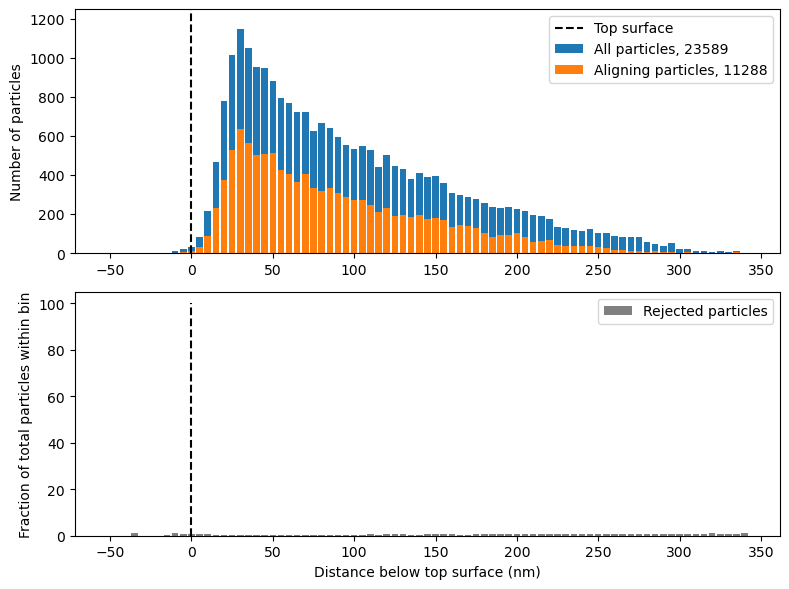

In [5]:
# Plot the distances
fig, [ax1,ax2] = plt.subplots(2, 1, figsize=(8, 6),)

bin_size_nm = 5
distance_bins = np.arange(-50, 350, bin_size_nm)
all_particle_bins = np.empty(len(distance_bins) - 1)
aligning_particle_bins = np.empty(len(distance_bins) - 1)

all_plot_df = pd.DataFrame()
aligning_plot_df = pd.DataFrame()
for i in range(len(distance_bins) - 1):
    particles_in_bin = out_particles_df[(out_particles_df["DistanceToTopNm"] > distance_bins[i]) & (out_particles_df["DistanceToTopNm"]  <= distance_bins[i+1])]
    aligning_particles_in_bin = aligning_particles_df[(aligning_particles_df["DistanceToTopNm"] > distance_bins[i]) & (aligning_particles_df["DistanceToTopNm"]  <= distance_bins[i+1])]
    all_particle_bins[i] = particles_in_bin.shape[0]
    aligning_particle_bins[i] = aligning_particles_in_bin.shape[0]

ax1.bar(distance_bins[:-1], all_particle_bins, label=f"All particles, {out_particles_df.shape[0]}", width=0.8*(distance_bins[1] - distance_bins[0]))
ax1.bar(distance_bins[:-1], aligning_particle_bins, label=f"Aligning particles, {aligning_particles_df.shape[0]}", width=0.8*(distance_bins[1] - distance_bins[0]))
ax1.vlines(0, 0, 2500, label="Top surface", color="k", linestyles="--")
ax1.set_ylabel("Number of particles")
ax1.legend()
ax1.set_ylim(0, all_particle_bins.max() + 100)

# Plot the percentage of particles in class 7 as a function of distance to top
distance_bins = np.arange(-50, 350, bin_size_nm)
rejected_fraction = np.empty(len(distance_bins) - 1)
aligning_fraction = np.empty(len(distance_bins) - 1)
for i in range(len(distance_bins) - 1):
    particles_in_bin = out_particles_df[(out_particles_df["DistanceToTopNm"] > distance_bins[i]) & (out_particles_df["DistanceToTopNm"]  <= distance_bins[i+1])]
    try: 
        rejected_fraction[i] = (- particles_in_bin[particles_in_bin["rlnClassNumber"] == 7].shape[0] + particles_in_bin.shape[0]) / particles_in_bin.shape[0]
    except:
        # if div zero
        rejected_fraction[i] = 0
    try:
        aligning_fraction[i] = (particles_in_bin[particles_in_bin["rlnClassNumber"] == 7].shape[0]) / particles_in_bin.shape[0]
    except:
        aligning_fraction[i] = 0


ax2.bar(distance_bins[:-1], rejected_fraction, label="Rejected particles", width=0.8*(distance_bins[1] - distance_bins[0]), color="grey")
ax2.vlines(0, 0, 100, color="k", linestyles="--")
ax2.set_xticks(np.arange(-50, 400, 50))
ax2.set_xlabel("Distance below top surface (nm)")
ax2.set_ylabel("Fraction of total particles within bin")
ax2.legend()

plt.tight_layout()
plt.savefig("/mnt/scratch/ribosomes/kas_k44a/particle_context/distance_to_top_div5grid.png", dpi=300)


NameError: name 'index' is not defined

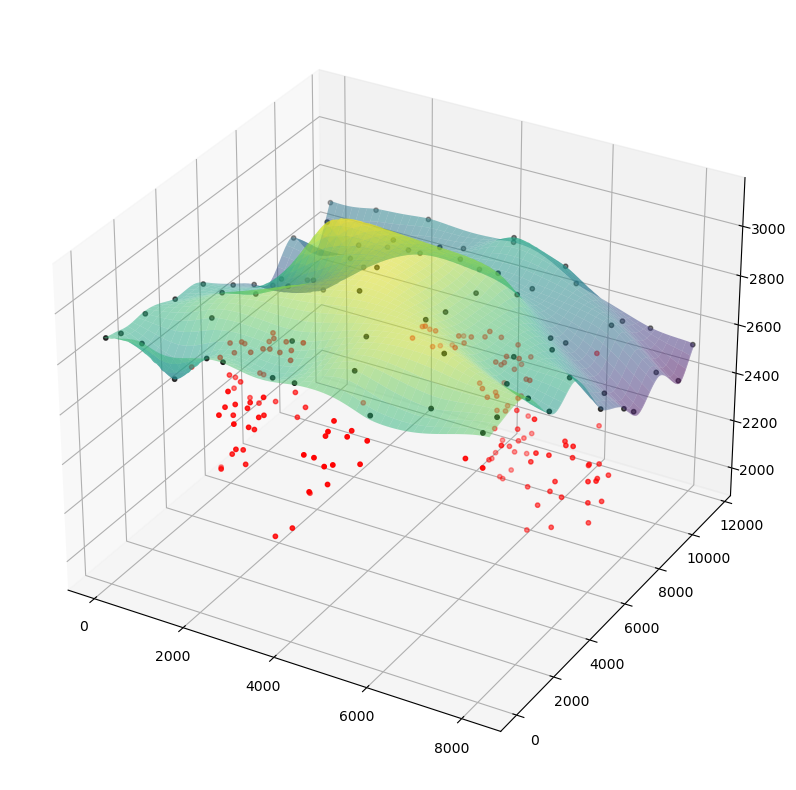

In [6]:
fig = plt.figure(figsize=(10, 10))
fig.tight_layout()
ax = fig.add_subplot(111, projection="3d")

# Plot the interpolated surface
ax.plot_surface(x_interp, y_interp, z_interp, cmap="viridis", alpha=0.5)
# Plot particles and model points
ax.scatter(ts_particles_df["rlnCoordinateX"], ts_particles_df["rlnCoordinateY"], ts_particles_df["rlnCoordinateZ"], color="red", s=10)
ax.scatter(model_df["x"], model_df["y"], model_df["z"], color="black", s=10)
ax.scatter(model_surface[index][0], model_surface[index][1], model_surface[index][2], color="blue", s=100)
ax.scatter(particle_i[0], particle_i[1], particle_i[2], color="green", s=100)
# Draw an arrow from one_particle_df down in Z
#for i in range(ts_particles.shape[0]):
#    ax.quiver(
#        ts_particles[i, 0], ts_particles[i, 1], ts_particles[i, 2],
#        0, 0, distances[i], color="red"
#    )

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(0, tomogram_dimensions[0])
ax.set_ylim(0, tomogram_dimensions[1])
ax.set_zlim(0, tomogram_dimensions[2])

In [ ]:
# Write out number of particles in each bin in a csv
out_df = pd.DataFrame({"DistanceToTopNm": distance_bins[:-1], "AllParticles": all_particle_bins, "AligningParticles": aligning_particle_bins})
out_df.to_csv(f"/mnt/scratch/ribosomes/kas_k44a/particle_context/numparticles_plot_data_bin{bin_size_nm}nm.csv", index=False)
out_percent_df = pd.DataFrame({"DistanceToTopNm": distance_bins[:-1], "RejectedFraction": rejected_fraction, "AligningFraction": aligning_fraction})
out_percent_df.to_csv(f"/mnt/scratch/ribosomes/kas_k44a/particle_context/fraction_plot_data_bin{bin_size_nm}nm.csv", index=False)

In [ ]:
particles_star_path = Path("/mnt/scratch/ribosomes/kas_k44a/particle_context/particle_data/job290_run_it050_data.star").absolute()   
good_class_number = 7
model_directory = Path("/mnt/scratch/ribosomes/kas_k44a/particle_context/surfaces_all/bottom").absolute()

model_binning = 10
pixel_size = 1.0825 # A/px

model_dimensions = [818, 1152, 480]
tomogram_dimensions = [dimension*model_binning for dimension in model_dimensions]

In [ ]:
particles_star = starfile.read(particles_star_path)
particles_df = particles_star['particles']

ts_names = particles_df['rlnTomoName'].unique()

In [ ]:
ts_names[:23]

array(['ts_003', 'ts_004', 'ts_005', 'ts_006', 'ts_007', 'ts_008',
       'ts_009', 'ts_012', 'ts_013', 'ts_014', 'ts_015', 'ts_016',
       'ts_017', 'ts_018', 'ts_020', 'ts_021', 'ts_022', 'ts_023',
       'ts_024', 'ts_026', 'ts_027', 'ts_028', 'ts_029'], dtype=object)

In [ ]:
divide_model_dimensions_by = 10
test_i = 0
distances_df = pd.DataFrame(columns=["DistanceToBottom"])

for ts_name in ts_names[:23]:
    model_file = model_directory / f"{ts_name}_bot.xyz"
    model_df = pd.read_csv(model_file, delim_whitespace=True, header=None, names=["x", "y", "z"]) * model_binning
    num_model_pts = model_df.shape[0]

    # Define an xy grid to interpolate over
    x_grid = np.linspace(0, tomogram_dimensions[0], int(model_dimensions[0] / divide_model_dimensions_by))
    y_grid = np.linspace(0, tomogram_dimensions[1], int(model_dimensions[1] / divide_model_dimensions_by))
    # Create a meshgrid from the x and y grids
    x_interp, y_interp = np.meshgrid(x_grid, y_grid)
    # Interpolate the model point values over the grid
    z_interp = np.empty((len(x_grid), len(y_grid)))
    interpolation = sp.interpolate.Rbf(model_df['x'], model_df['y'], model_df['z'], function='thin_plate', smooth=5, epsilon=5)
    z_interp = interpolation(x_interp, y_interp)

    model_surface = np.dstack((x_interp, y_interp, z_interp))

    ts_particles_df = particles_df[particles_df['rlnTomoName'] == ts_name]
    ts_particles_xyz = ts_particles_df[["rlnCoordinateX", "rlnCoordinateY", "rlnCoordinateZ"]].to_numpy()

    distances = np.empty((ts_particles_xyz.shape[0], 1)) # shape is (num_particles, num_surfaces)

    for i, particle_i in enumerate(ts_particles_xyz):
        # Calculate the norm from the particle position to each interpolated point and keep the minimum
        distances[i] = np.min(np.linalg.norm(model_surface - particle_i, axis=2)) # or use nanmin
        closest_grid_pt_indices = np.unravel_index(np.argmin(np.linalg.norm(model_surface - particle_i, axis=2)), model_surface.shape[:2])
        closest_grid_pt = model_surface[closest_grid_pt_indices[0], closest_grid_pt_indices[1]]
        z_diff = - closest_grid_pt[2] + particle_i[2] 
        pos_or_neg = np.sign(z_diff)
        distances[i] = pos_or_neg * distances[i]

        #z_surface_check = model_surface[grid_xy_check[0], grid_xy_check[1], 2]

    distances_df = pd.concat([distances_df, pd.DataFrame(distances, columns=["DistanceToBottom"])], ignore_index=True)
out_particles_df = particles_df.copy()
out_particles_df["DistanceToBottomNm"] = distances_df * pixel_size / 10 # convert from px to nm
aligning_particles_df = out_particles_df[out_particles_df['rlnClassNumber'] == good_class_number]

dimensions / 10 ==> 18.8s \
4x num pts ==> 2m 57.0s

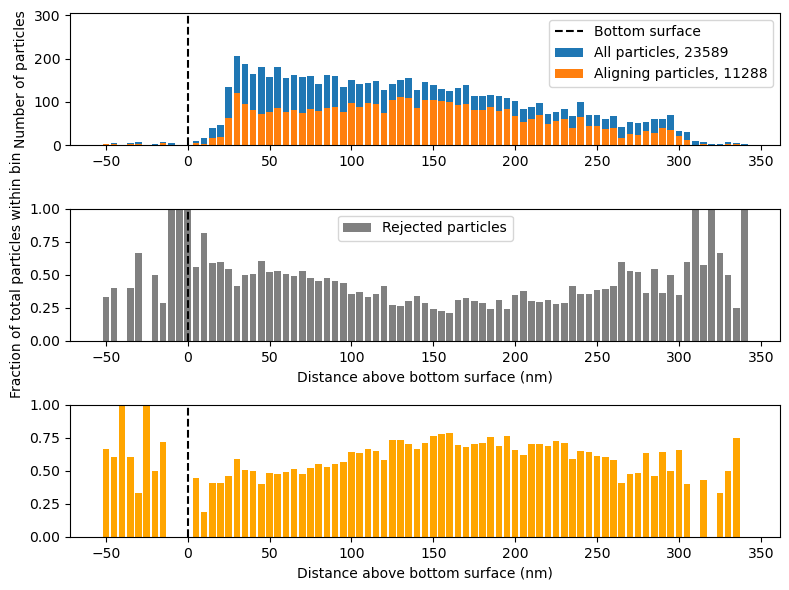

In [ ]:
# Plot the distances
fig, [ax1,ax2,ax3] = plt.subplots(3, 1, figsize=(8, 6),)

bin_size_nm = 5
distance_bins = np.arange(-50, 350, bin_size_nm)
all_particle_bins = np.empty(len(distance_bins) - 1)
aligning_particle_bins = np.empty(len(distance_bins) - 1)

all_plot_df = pd.DataFrame()
aligning_plot_df = pd.DataFrame()
for i in range(len(distance_bins) - 1):
    particles_in_bin = out_particles_df[(out_particles_df["DistanceToBottomNm"] > distance_bins[i]) & (out_particles_df["DistanceToBottomNm"]  <= distance_bins[i+1])]
    aligning_particles_in_bin = aligning_particles_df[(aligning_particles_df["DistanceToBottomNm"] > distance_bins[i]) & (aligning_particles_df["DistanceToBottomNm"]  <= distance_bins[i+1])]
    all_particle_bins[i] = particles_in_bin.shape[0]
    aligning_particle_bins[i] = aligning_particles_in_bin.shape[0]

ax1.bar(distance_bins[:-1], all_particle_bins, label=f"All particles, {out_particles_df.shape[0]}", width=0.8*(distance_bins[1] - distance_bins[0]))
ax1.bar(distance_bins[:-1], aligning_particle_bins, label=f"Aligning particles, {aligning_particles_df.shape[0]}", width=0.8*(distance_bins[1] - distance_bins[0]))
ax1.vlines(0, 0, 2500, label="Bottom surface", color="k", linestyles="--")
ax1.set_ylabel("Number of particles")
ax1.legend()
ax1.set_ylim(0, all_particle_bins.max() + 100)

# Plot the percentage of particles in class 7 as a function of distance to top
distance_bins = np.arange(-50, 350, bin_size_nm)
rejected_fraction = np.empty(len(distance_bins) - 1)
aligning_fraction = np.empty(len(distance_bins) - 1)
for i in range(len(distance_bins) - 1):
    particles_in_bin = out_particles_df[(out_particles_df["DistanceToBottomNm"] > distance_bins[i]) & (out_particles_df["DistanceToBottomNm"]  <= distance_bins[i+1])]
    try: 
        rejected_fraction[i] = (- particles_in_bin[particles_in_bin["rlnClassNumber"] == 7].shape[0] + particles_in_bin.shape[0]) / particles_in_bin.shape[0]
    except:
        # if div zero
        rejected_fraction[i] = 0
    try:
        aligning_fraction[i] = (particles_in_bin[particles_in_bin["rlnClassNumber"] == 7].shape[0]) / particles_in_bin.shape[0]
    except:
        aligning_fraction[i] = 0


ax2.bar(distance_bins[:-1], rejected_fraction, label="Rejected particles", width=0.8*(distance_bins[1] - distance_bins[0]), color="grey")
ax2.vlines(0, 0, 100, color="k", linestyles="--")
ax2.set_ylim(0, 1)
ax2.set_xticks(np.arange(-50, 400, 50))
ax2.set_xlabel("Distance above bottom surface (nm)")
ax2.set_ylabel("Fraction of total particles within bin")
ax2.legend()

ax3.bar(distance_bins[:-1], aligning_fraction, label="Aligning particles", width=0.8*(distance_bins[1] - distance_bins[0]), color="orange")
ax3.vlines(0, 0, 1, color="k", linestyles="--")
ax3.set_ylim(0, 1)
ax3.set_xticks(np.arange(-50, 400, 50))
ax3.set_xlabel("Distance above bottom surface (nm)")

plt.tight_layout()
plt.savefig("/mnt/scratch/ribosomes/kas_k44a/particle_context/distance_to_bottom_div10grid.png", dpi=300)


(0.0, 4800.0)

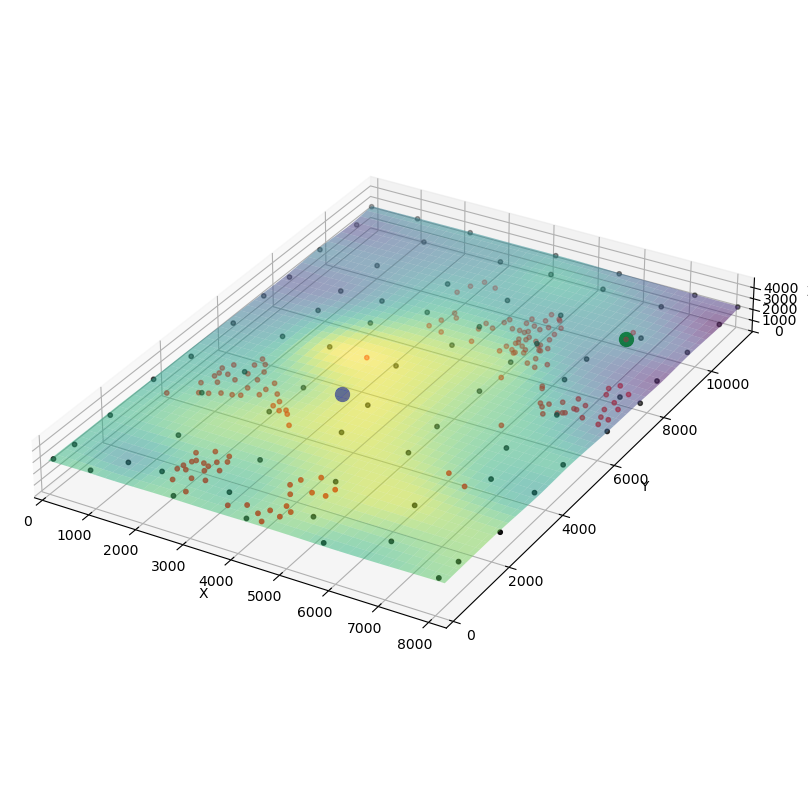

In [ ]:
fig = plt.figure(figsize=(10, 10))
fig.tight_layout()
ax = fig.add_subplot(111, projection="3d")

# Plot the interpolated surface
ax.plot_surface(x_interp, y_interp, z_interp, cmap="viridis", alpha=0.5)
# Plot particles and model points
ax.scatter(ts_particles_df["rlnCoordinateX"], ts_particles_df["rlnCoordinateY"], ts_particles_df["rlnCoordinateZ"], color="red", s=10)
ax.scatter(model_df["x"], model_df["y"], model_df["z"], color="black", s=10)
ax.scatter(model_surface[index][0], model_surface[index][1], model_surface[index][2], color="blue", s=100)
ax.scatter(particle_i[0], particle_i[1], particle_i[2], color="green", s=100)
# Draw an arrow from one_particle_df down in Z
#for i in range(ts_particles.shape[0]):
#    ax.quiver(
#        ts_particles[i, 0], ts_particles[i, 1], ts_particles[i, 2],
#        0, 0, distances[i], color="red"
#    )

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(0, tomogram_dimensions[0])
ax.set_ylim(0, tomogram_dimensions[1])
ax.set_zlim(0, tomogram_dimensions[2])

In [ ]:
# Write out number of particles in each bin in a csv
out_df = pd.DataFrame({"DistanceToTopNm": distance_bins[:-1], "AllParticles": all_particle_bins, "AligningParticles": aligning_particle_bins})
out_df.to_csv(f"/mnt/scratch/ribosomes/kas_k44a/particle_context/numparticles_plot_data_bin{bin_size_nm}nm.csv", index=False)
out_percent_df = pd.DataFrame({"DistanceToTopNm": distance_bins[:-1], "RejectedFraction": rejected_fraction, "AligningFraction": aligning_fraction})
out_percent_df.to_csv(f"/mnt/scratch/ribosomes/kas_k44a/particle_context/fraction_plot_data_bin{bin_size_nm}nm.csv", index=False)